Author: Abdelmalik Moujahid -- abdelmalik.moujahid@uc3m.es

Date: April 4, 2017

Written by: <b> Alessandro La Corte</b>



# Machine Learning

## Session #7: The Expectation Maximization algorithm for Gaussian Mixture models


We are given a dataset $D=\{\textbf{x}_1,\textbf{x}_2,...,\textbf{x}_N\}$, where $\textbf{x}_i$ is a $d$-dimentional vector.

* Assume that the data points are generated in an i.i.d pattern from an underlying density function $p(\textbf{x})$.
* We further assume that $p(\textbf{x})$ is defined as a mixture of $K$ Gaussian components:

$$p(\textbf{x}|\theta)=\sum_z p(\textbf{z})p(\textbf{x}|\textbf{z},\theta)=\sum_{k=1}^K\pi_k N(\textbf{x}|\mu_k,\Sigma_k)$$

- $\textbf{z}$ is a $K$-dimentional binary variable. The values of $z_k$ satisfy $z_k\in\{0,1\}$ and $\sum_k z_k=1$.
- The $\pi_k=p(z_k=1)$ are rhe mixture weights (or mixing coefficients), representing the probability that a randomly selected $\textbf{x}$ was generated by component $k$, where $\sum_k\pi_k=1$



### EM for Gaussian Mixtures

* Initialize the mean $\mu_k$, covariances $\Sigma_k$ and mixing coefficients $\pi_k$, and evaluate the initial value of the log likelihood.
* **E-step.** Compute the membership weights 

$$w_{nk}=\frac{\pi_k N(\textbf{x}_n|\mu_k,\Sigma_k)}{\sum_{j=1}^K \pi_jN(\textbf{x}_n|\mu_j,\Sigma_j)}$$

* **M-step.** Reestimate the parameters using the current membership weights

$$\mu_k^{new}=\frac{1}{N_k}\sum_{n=1}^N w_{nk} \textbf{x}_n$$

$$\Sigma_k^{new}=\frac{1}{N_k}\sum_{n=1}^N w_{nk} (\textbf{x}_n-\mu_k^{new})(\textbf{x}_n-\mu_k^{new})^T$$

$$\pi_k^{new}=\frac{N_k}{N}$$ where $N_k=\sum_{n=1}^Nw_{nk}$

* Evaluate the log likelihood

$$ln\quad p(\textbf{X}|\mu,\Sigma,\pi)=\sum_{n=1}^N ln \{\sum_{k=1}^K \pi_k N(\textbf{x}_n|\mu_k,\Sigma_k)\}$$

### Initialization

The EM algorithm can be started by either initializing the algorithm by a set of parameters and then conducting an E-step, or by starting with a set of initial membership weights and then doing a M-step.

The initial parameters or weights can be chosen randomly or could be chosen via some heuristic method (such as by using the K-means to cluster the data and then defining weights based on K-means membership).



## Required packages:

    * import numpy as np

    * from matplotlib import pyplot as plt
    * from sklearn import metrics, datasets
    * from sklearn.preprocessing import scale
       
    * from scipy.stats import multivariate_normal as mvn
    
    

## Tasks


* Generate some data from a Gaussian mixture model
* Impelement the EM algorithm following the steps desribed above adopting different initializations.
 


In [13]:
#All imports

import numpy               as np
import matplotlib.mlab     as mlab
from matplotlib            import pyplot as plt
from sklearn               import metrics, datasets, mixture
from sklearn.preprocessing import scale
from scipy.stats           import multivariate_normal as mvn

* Generate some data from a Gaussian mixture model

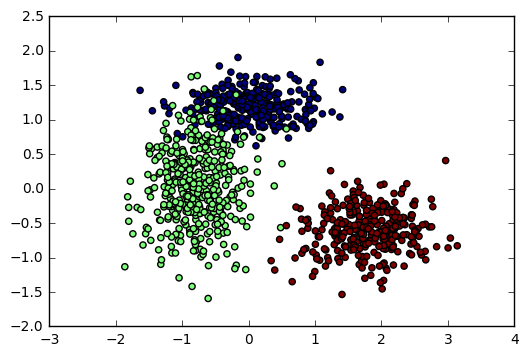

In [4]:
#we define the parameters of a mixture of 3 Gaussian
mus = np.array([[0,4], [-2,0], [6,-2]])
sigmas = np.array([   [[3, 0], [0, 0.5]], [[1,0],[0,2]], [[3,0],[0,1]] ])
pis = np.array([0.3, 0.4, 0.3])

# we generate some data from the above mixture
samples=1000
dim=2
data = []
label= []
k=1
for pi, mu, sigma in zip(pis, mus, sigmas):
    components_samples=np.int(pi*samples)
    data.append(pi*mvn.rvs(mu, sigma,components_samples))
    label.append([k]*(components_samples))
    k = k+1

data=np.asarray(data)
label=np.asarray(label)
data=np.concatenate((data[0], data[1], data[2]), axis=0)
label=np.concatenate((label[0], label[1], label[2]), axis=0)


plt.scatter(data[:,0],data[:,1],c=label)
plt.show()



* Impelement the EM algorithm following the steps desribed above adopting different initializations.

In [5]:

def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [9]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make a copy of initial parameters
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Determine dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize  log likelikehood
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] = weights[k] * mvn.pdf(data[j], means[k], covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        
        # normalize over all possible cluster assignments
        resp = resp / row_sums 

        # M-step
        counts = np.sum(resp, axis=0)
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight.
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += resp[j,k]*data[j]
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                weighted_sum += resp[j,k] * np.outer(data[j] - means[k], data[j] - means[k])
            covariances[k] = weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [10]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 37


In [49]:

def plot_contours(data, means, covs, title):
    plt.figure()
    plt.scatter([x[0] for x in data], [y[1] for y in data], c=label)

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'indigo', 'red']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':8})
    plt.show()

<b> Plots </b>

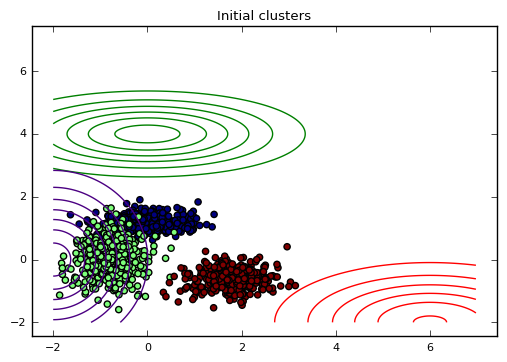

In [50]:
# Parameters after initialization
plot_contours(data, mus, sigmas, 'Initial clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 37


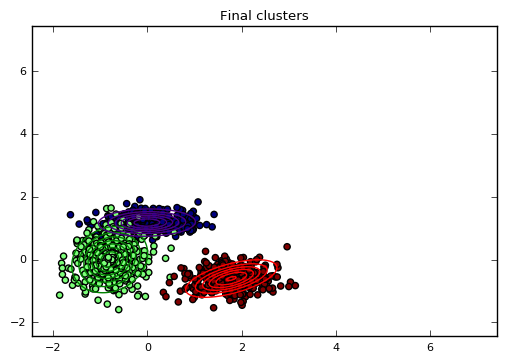

In [51]:
# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')